In [ ]:
import sys
import os

current_notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root_dir = os.path.abspath(os.path.join(current_notebook_dir, '../../'))

# 将这个父目录添加到sys.path的最前面
if project_root_dir not in sys.path:
    sys.path.insert(0, project_root_dir)

print(sys.path)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from pytorch_script.visual_utils import plot_acc_losses, plot_epochs_losses_distribution, plot_losses_distribution_and_contribution

In [ ]:
train_accuracies = np.load('train_accuracies.npy')
test_accuracies = np.load('test_accuracies.npy')
train_losses = np.load('train_losses.npy')
test_losses = np.load('test_losses.npy')
epochs = np.load('epochs.npy')
epochs = [  0,  5,  10,  20,  30,
        40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160,
       170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290,
       300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420,
       430, 440, 450, 460, 470, 480, 490, 500]

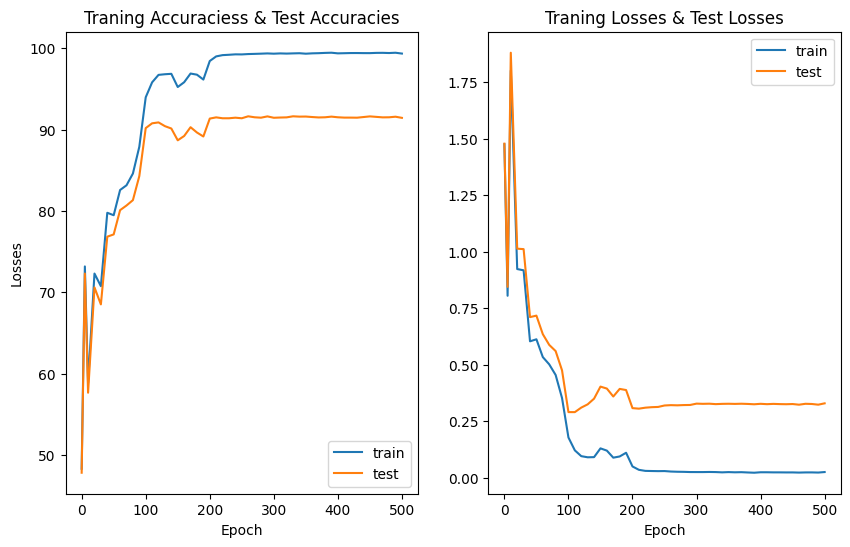

In [24]:
plot_acc_losses(epochs, train_accuracies, test_accuracies, train_losses, test_losses)

In [19]:
import pickle
with open('all_model_train_losses.pickle', 'rb') as f: 
	all_model_train_losses = pickle.load(f)

with open('all_model_test_losses.pickle', 'rb') as f: 
	all_model_test_losses = pickle.load(f)

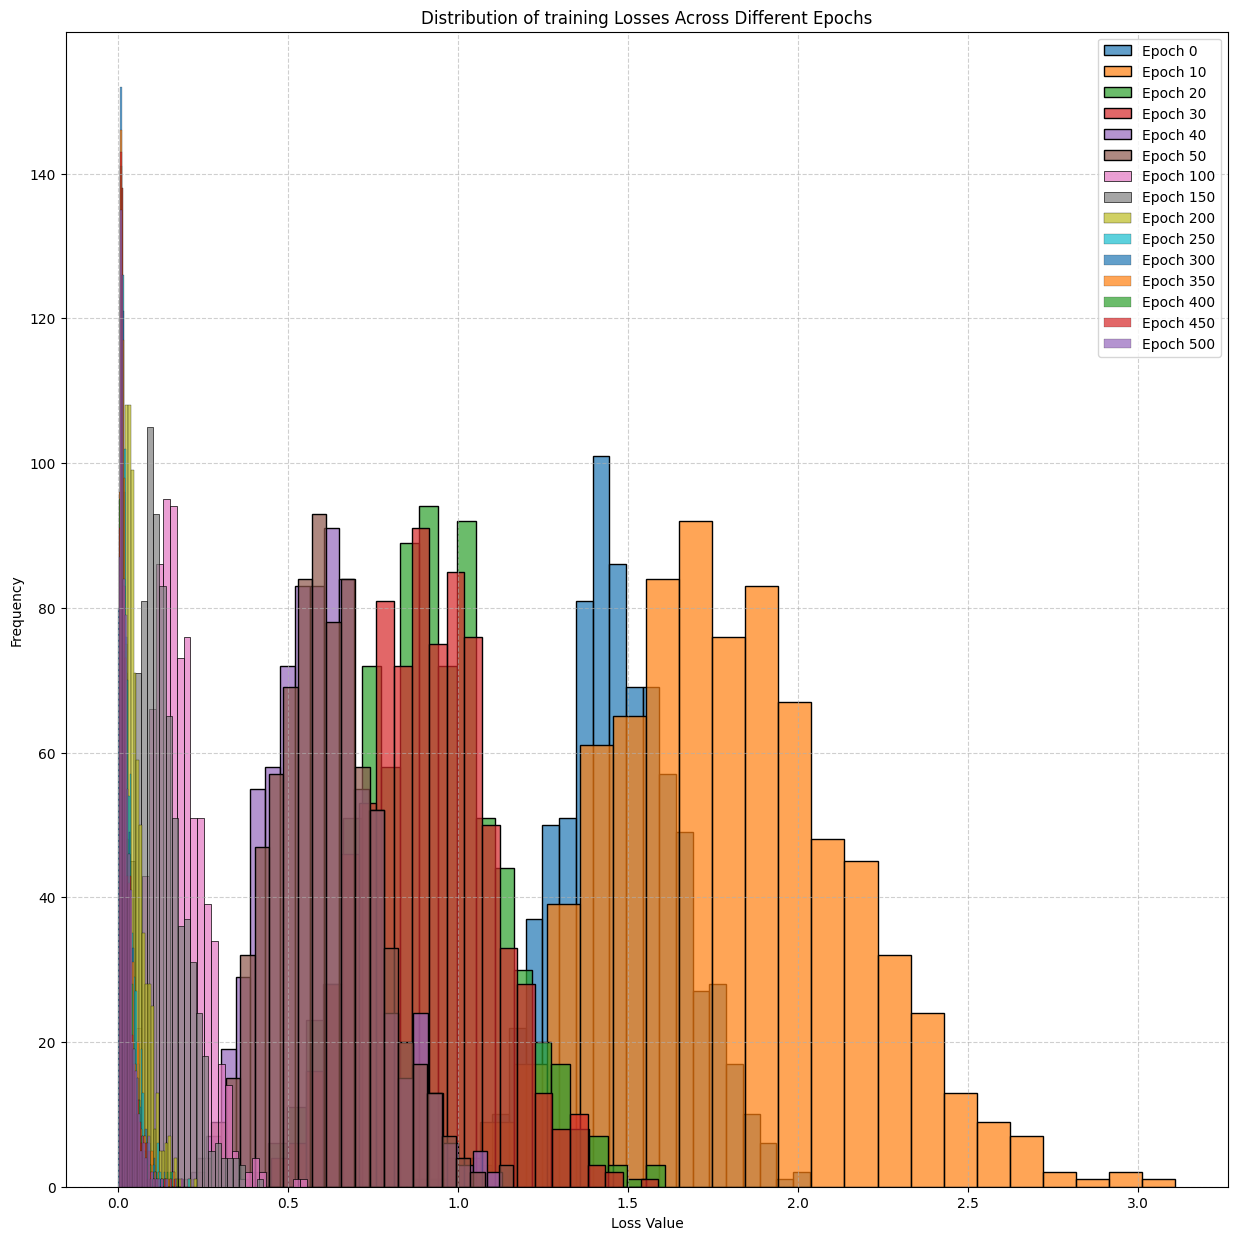

In [20]:
plot_epochs_losses_distribution('train', all_model_train_losses, [0, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])

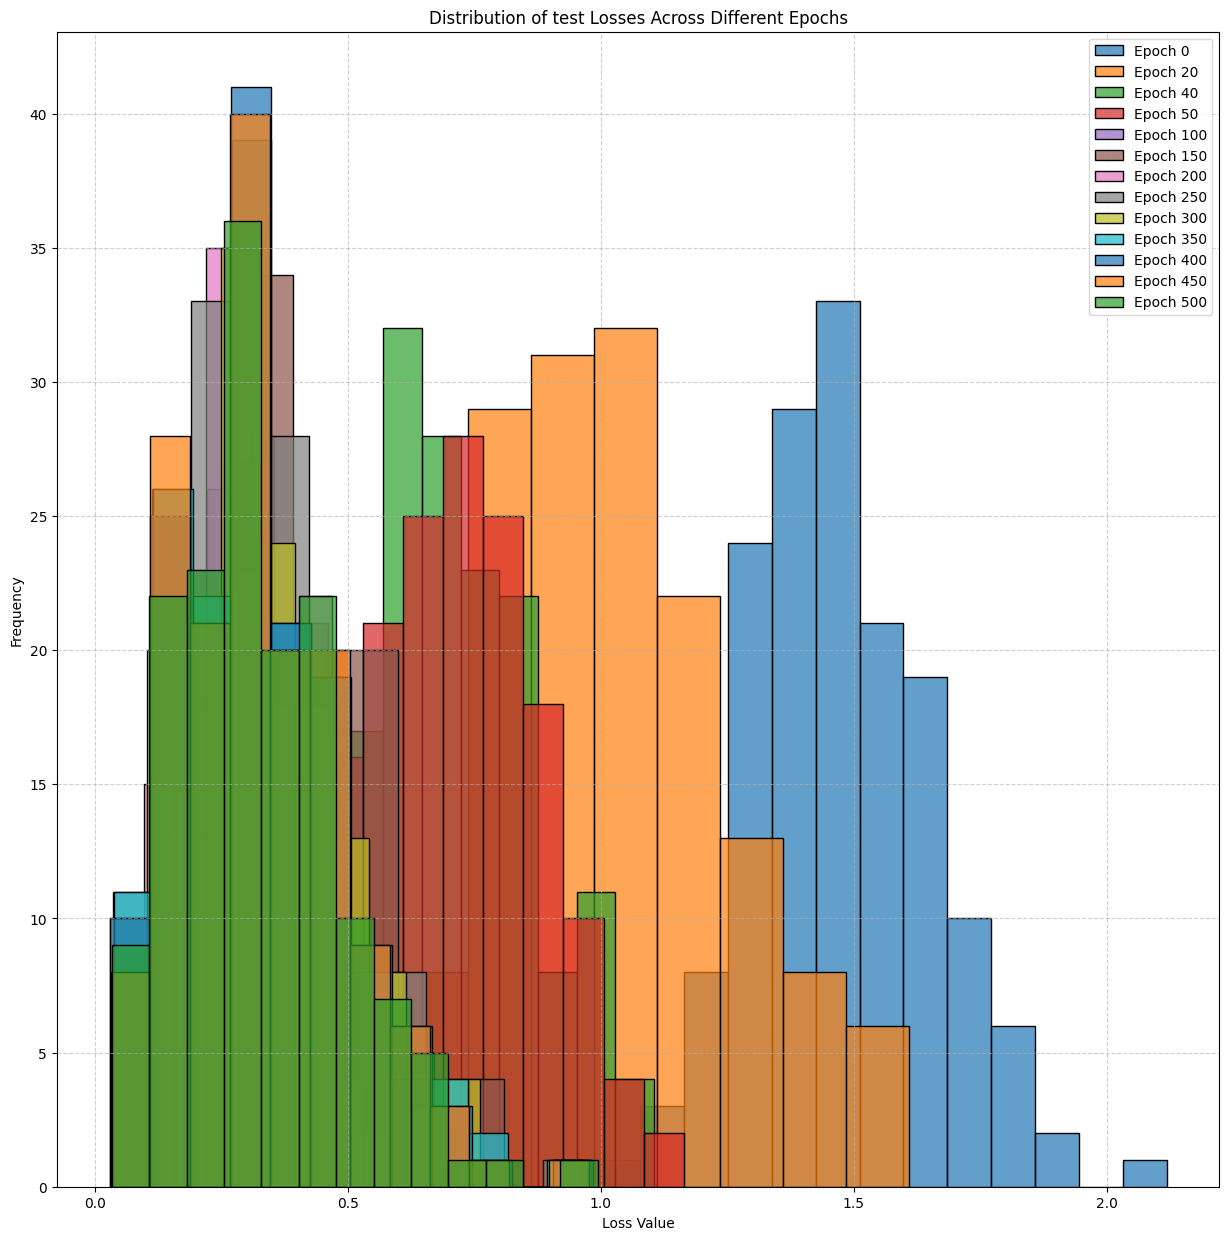

In [21]:
plot_epochs_losses_distribution('test', all_model_test_losses, [0, 20 , 40, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])

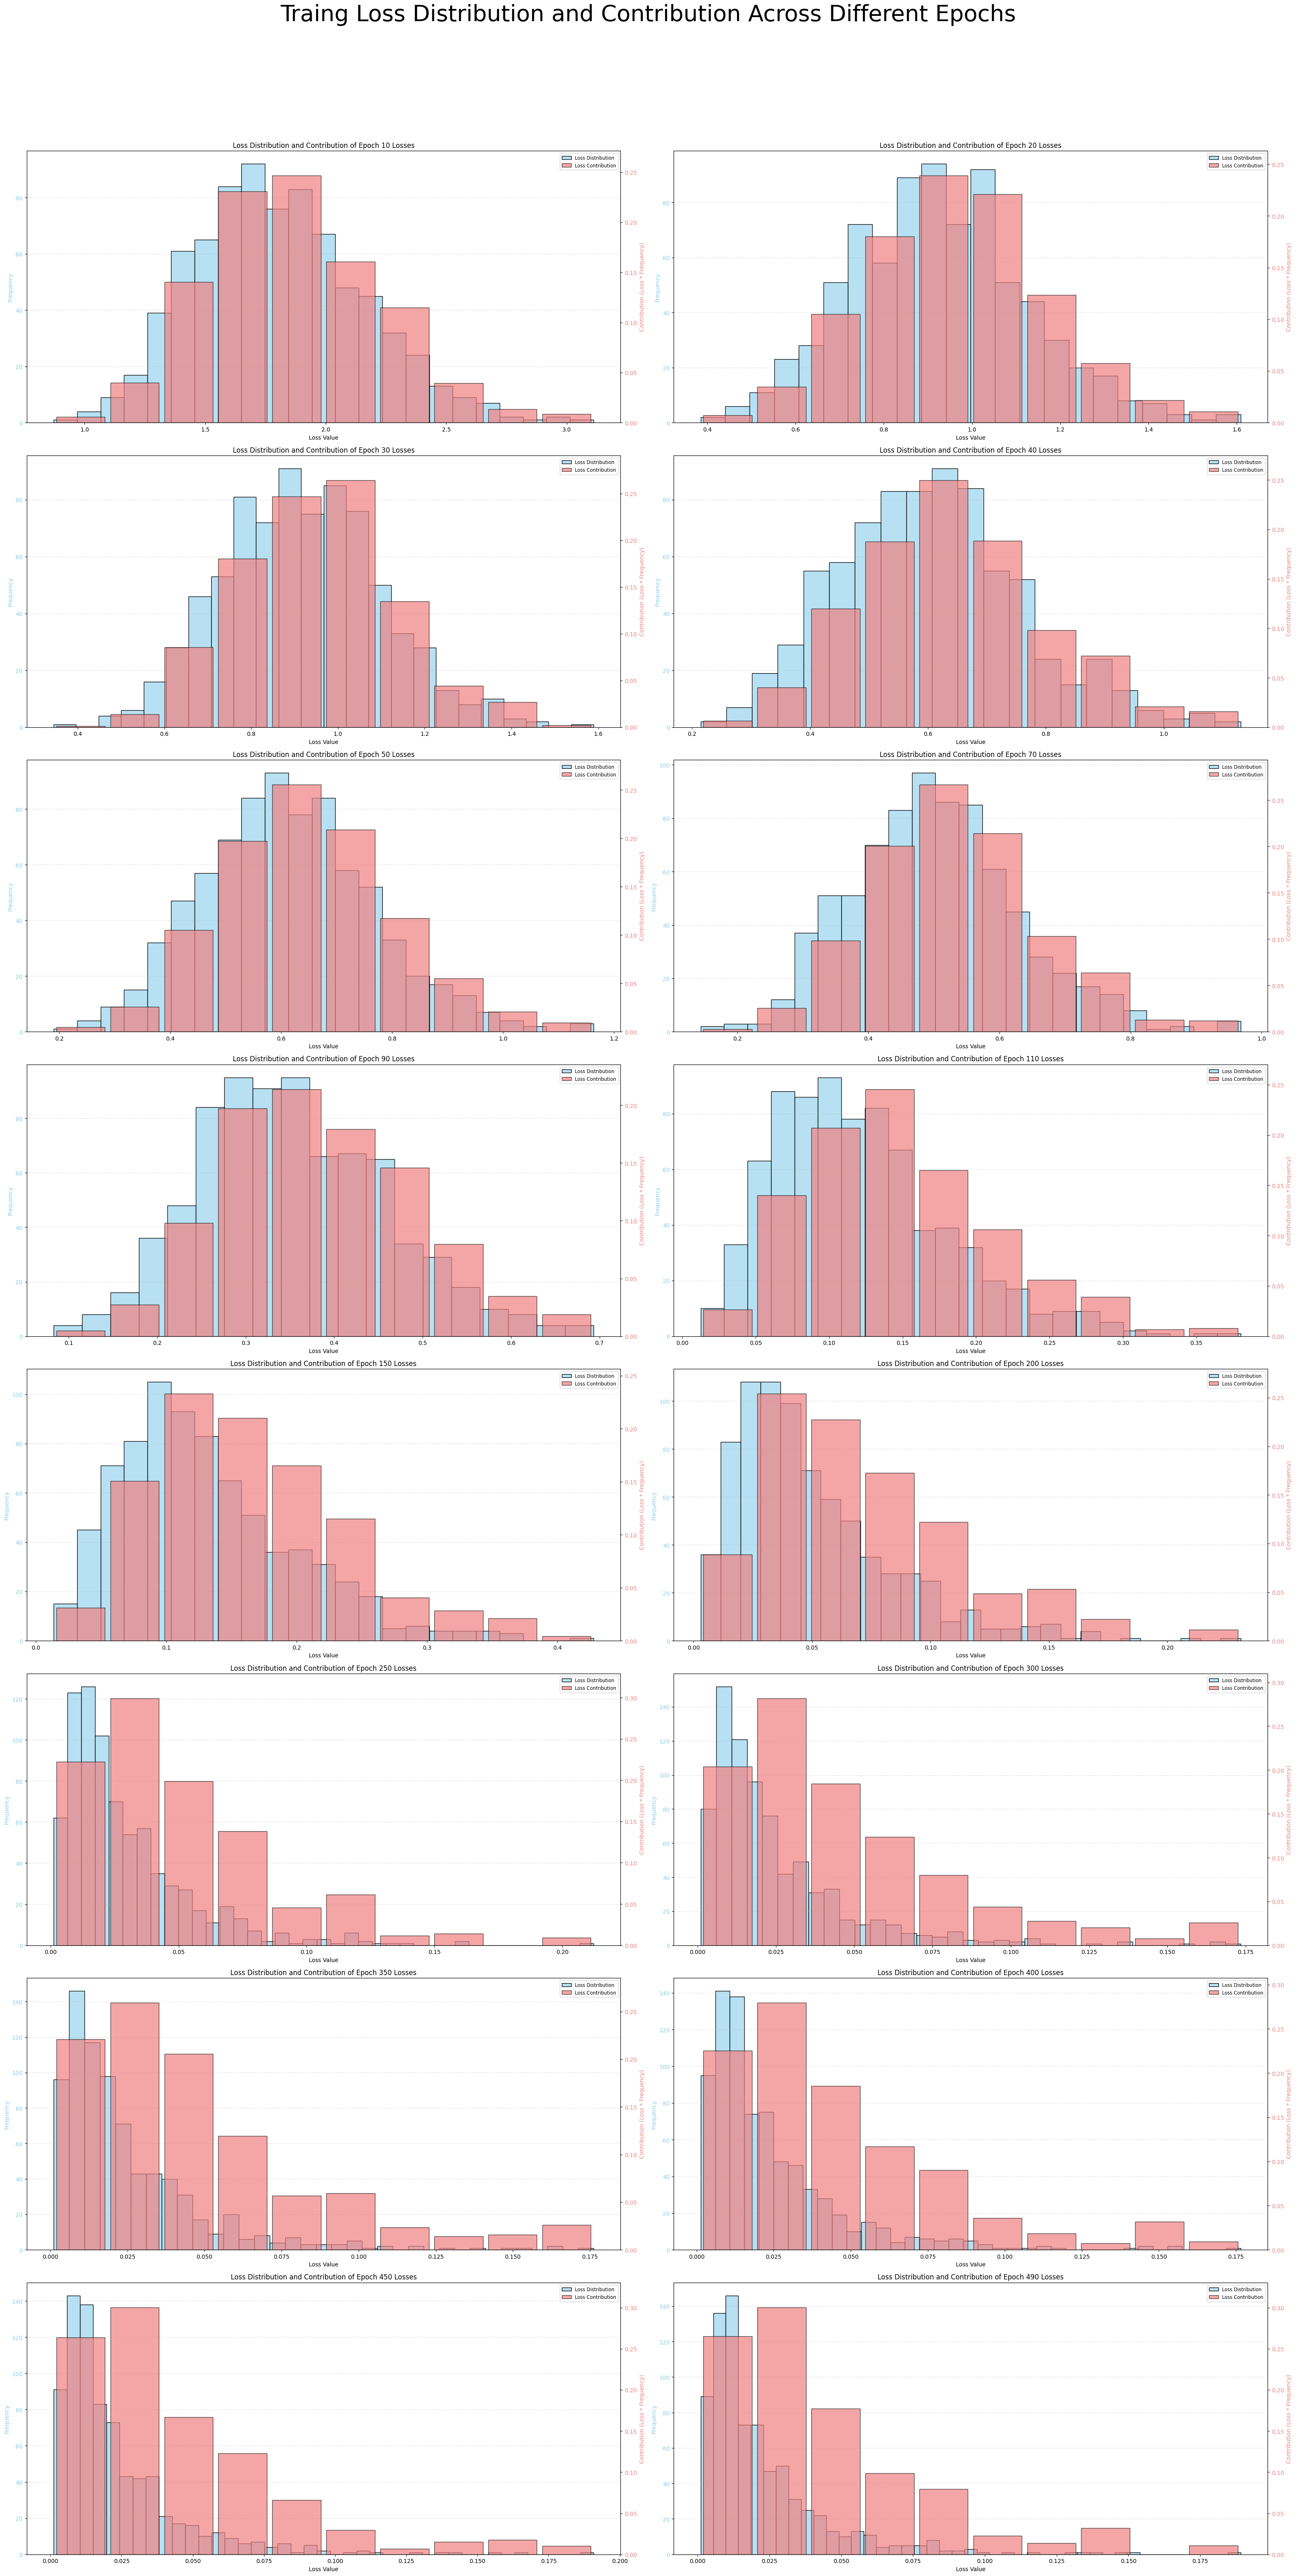

In [22]:
fig, axes = plt.subplots(8, 2, figsize=(32, 64)) # 增加了 figsize
axes_flat = axes.flatten()

epoch_indices_to_plot = [10, 20, 30, 40, 50, 70, 90, 110, 150, 200, 250, 300, 350, 400, 450, 490]

# 遍历 epoch 索引，并将其映射到扁平化的 axes 数组中的每个子图
for i, epoch_index in enumerate(epoch_indices_to_plot):
    plot_losses_distribution_and_contribution(epoch_index, all_model_train_losses[epoch_index], axes_flat[i])

# 设置整个 Figure 的总标题
fig.suptitle('Traing Loss Distribution and Contribution Across Different Epochs', fontsize=40, y=1.02) # y 调整标题位置

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 调整布局，为总标题留出空间
plt.show()

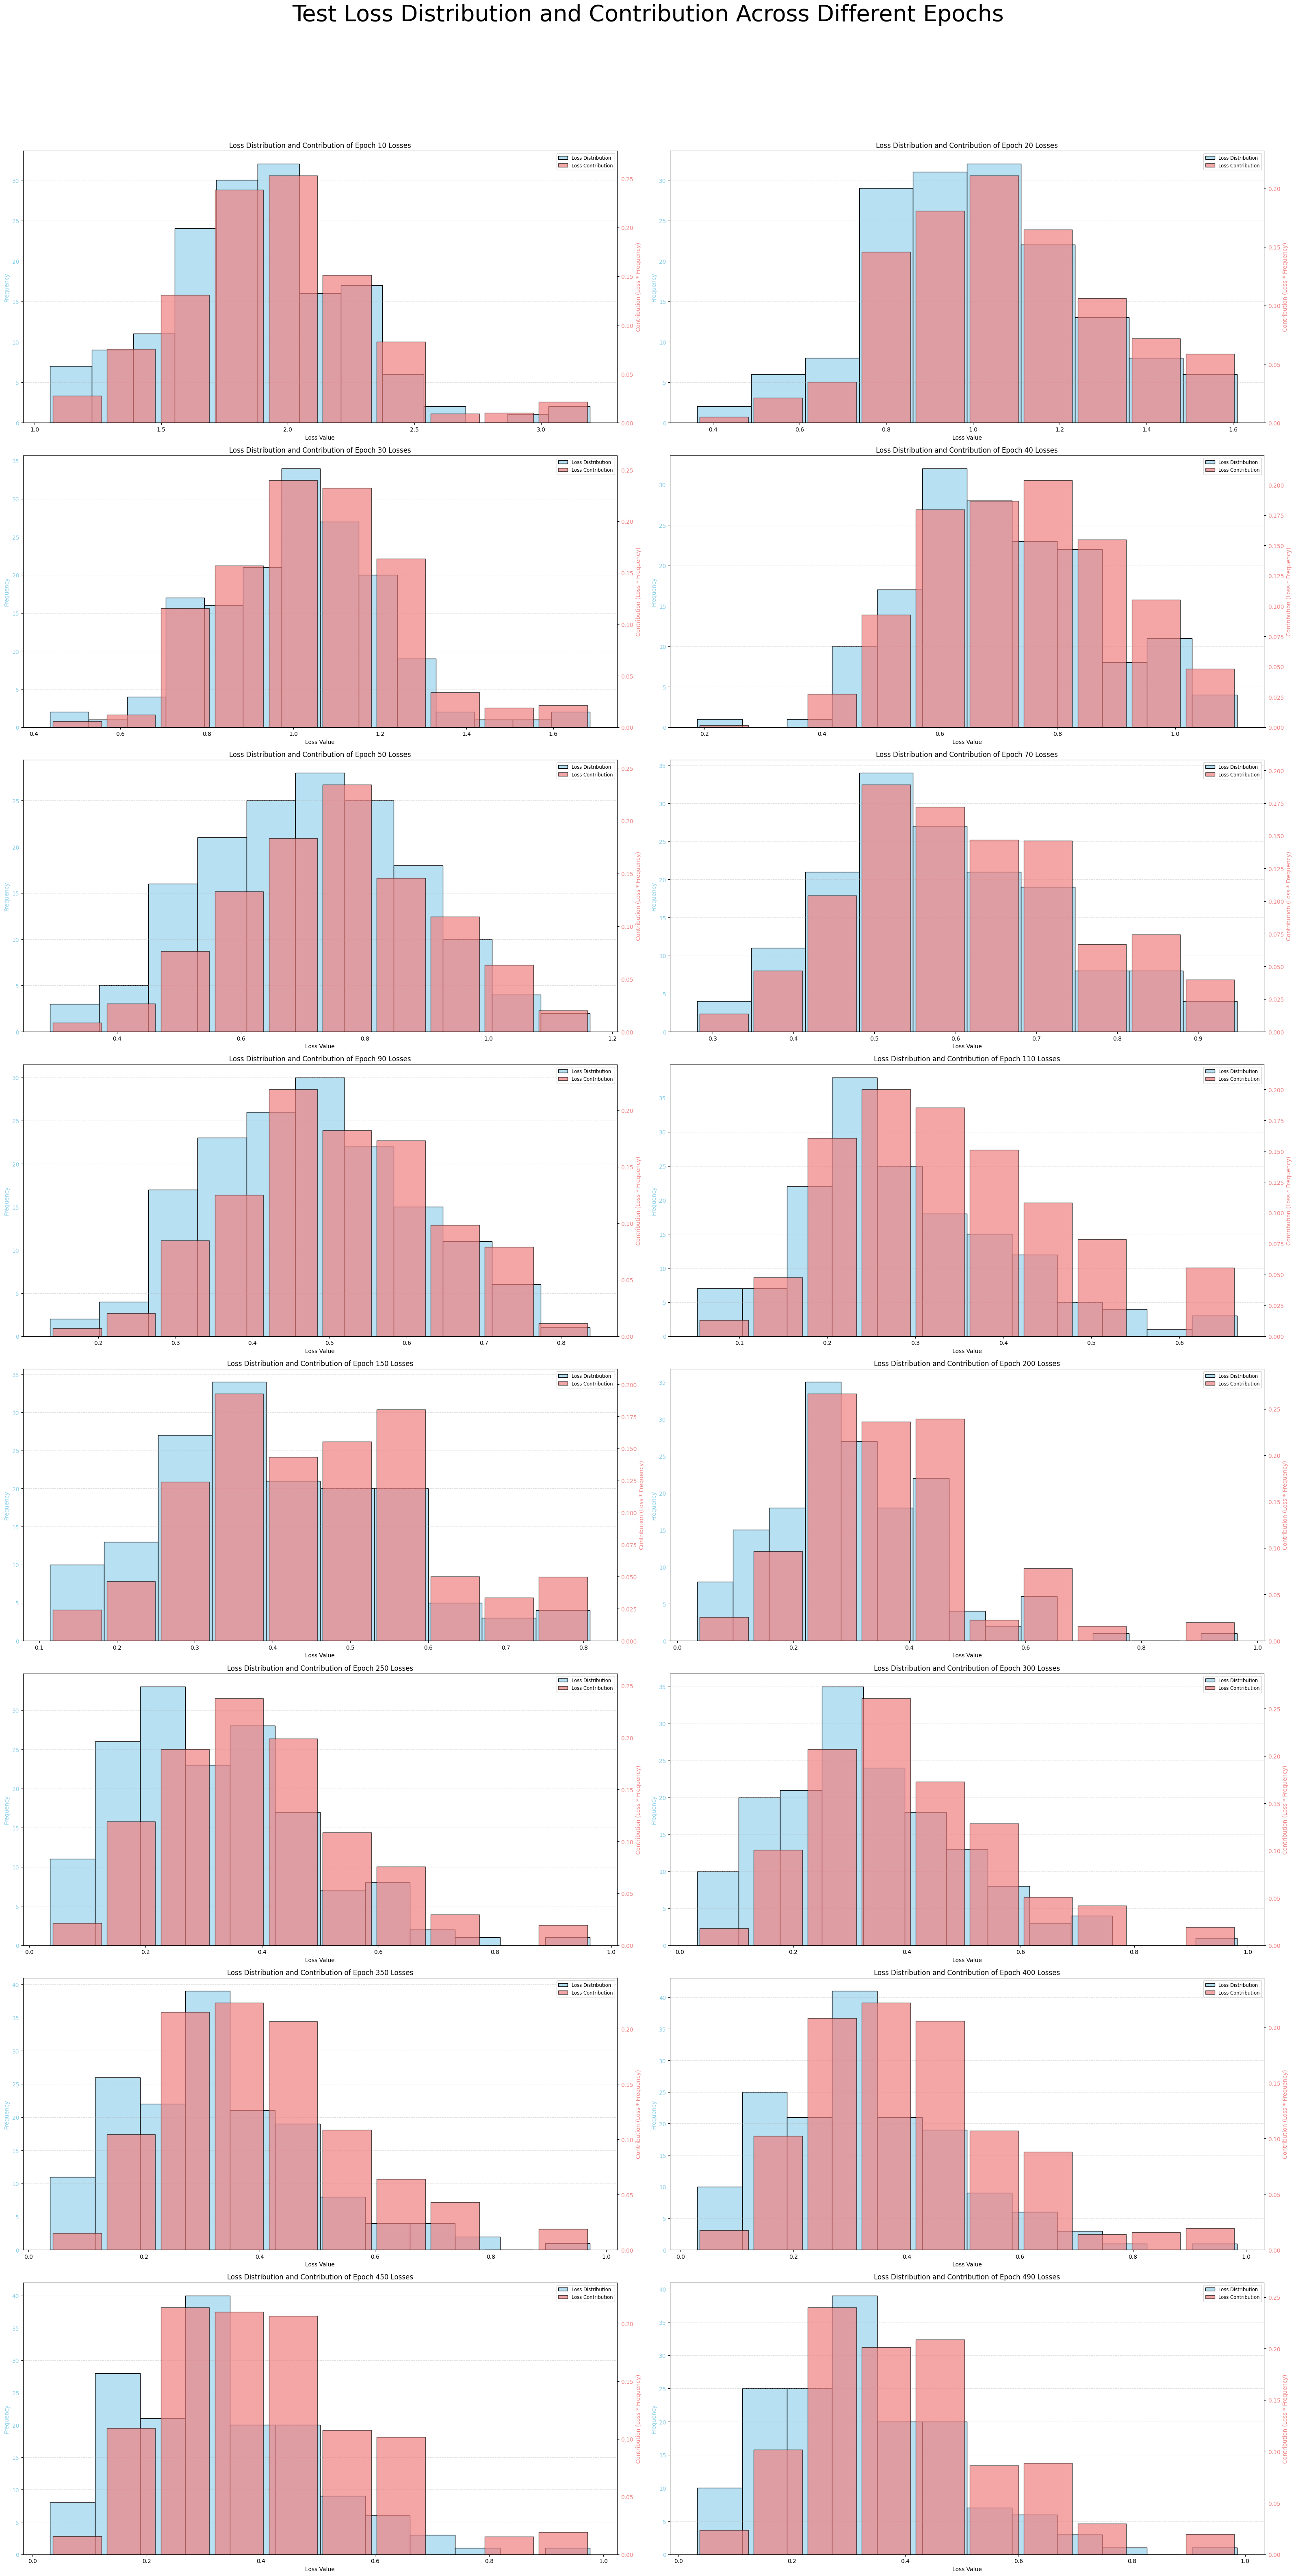

In [23]:
fig, axes = plt.subplots(8, 2, figsize=(32, 64)) # 增加了 figsize
axes_flat = axes.flatten()

epoch_indices_to_plot = [10, 20, 30, 40, 50, 70, 90, 110, 150, 200, 250, 300, 350, 400, 450, 490]

# 遍历 epoch 索引，并将其映射到扁平化的 axes 数组中的每个子图
for i, epoch_index in enumerate(epoch_indices_to_plot):
    plot_losses_distribution_and_contribution(epoch_index, all_model_test_losses[epoch_index], axes_flat[i])

# 设置整个 Figure 的总标题
fig.suptitle('Test Loss Distribution and Contribution Across Different Epochs', fontsize=40, y=1.02) # y 调整标题位置

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 调整布局，为总标题留出空间
plt.show()